In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
url = 'FB.csv'
meta = pd.read_csv(url)
meta = meta.dropna(how='any',axis=0) #If there is missing data
meta['Date'].apply(pd.to_datetime) #For ease of adjusting dates later on
len(meta.index)

2382

In [3]:
meta = meta[['Close'] + [col for col in meta if col not in ['Adj Close', 'Close', 'Date']] + ['Adj Close', 'Date']]

In [4]:
meta = meta.sort_values('Date')
meta.head()

,Close,Open,High,Low,Volume,Adj Close,Date
0,38.230000,42.049999,45.000000,38.000000,573576400,38.230000,2012-05-18
1,34.029999,36.529999,36.660000,33.000000,168192700,34.029999,2012-05-21
2,31.000000,32.610001,33.590000,30.940001,101786600,31.000000,2012-05-22
3,32.000000,31.370001,32.500000,31.360001,73600000,32.000000,2012-05-23
4,33.029999,32.950001,33.209999,31.770000,50237200,33.029999,2012-05-24


For stock prices, we can use the closing price of each day.

Visualising the stock price variations

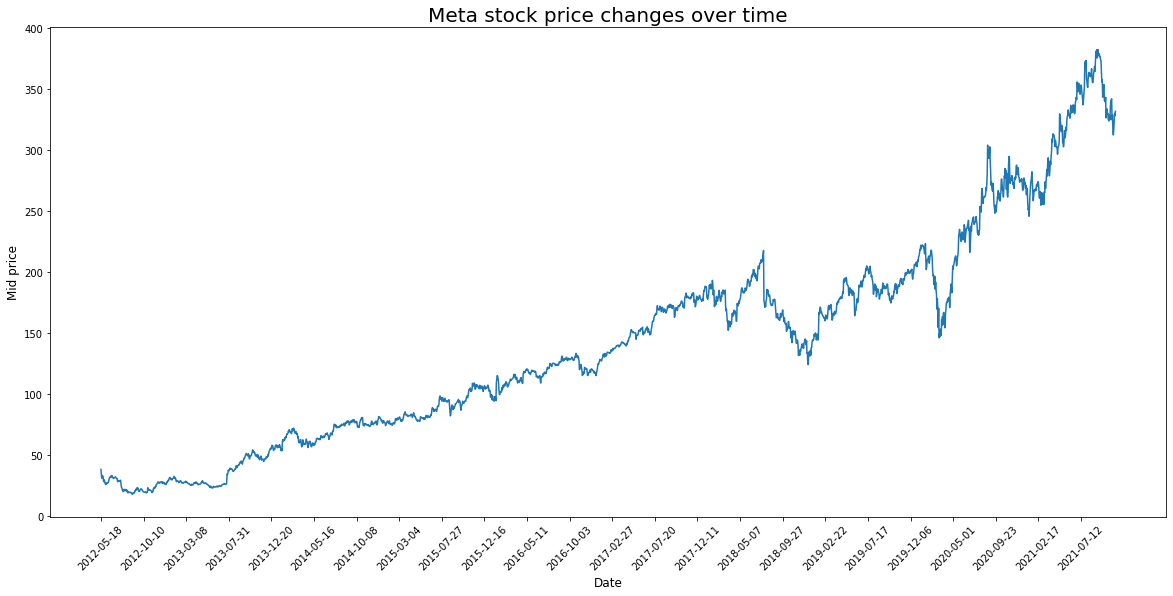

In [5]:
plt.figure(figsize = (20,9))
plt.plot(meta.Date, meta.Close)
plt.xticks(range(0,meta.shape[0],100),meta['Date'].loc[::100],rotation=45)
plt.xlabel('Date',fontsize=12)
plt.ylabel('Mid price',fontsize=12)
plt.title('Meta stock price changes over time',fontsize=20)
plt.show()

Another visualisation of the prices using long and short moving averages.

In [6]:
short_MA = meta.rolling(window=15).mean()
long_MA = meta.rolling(window=80).mean()

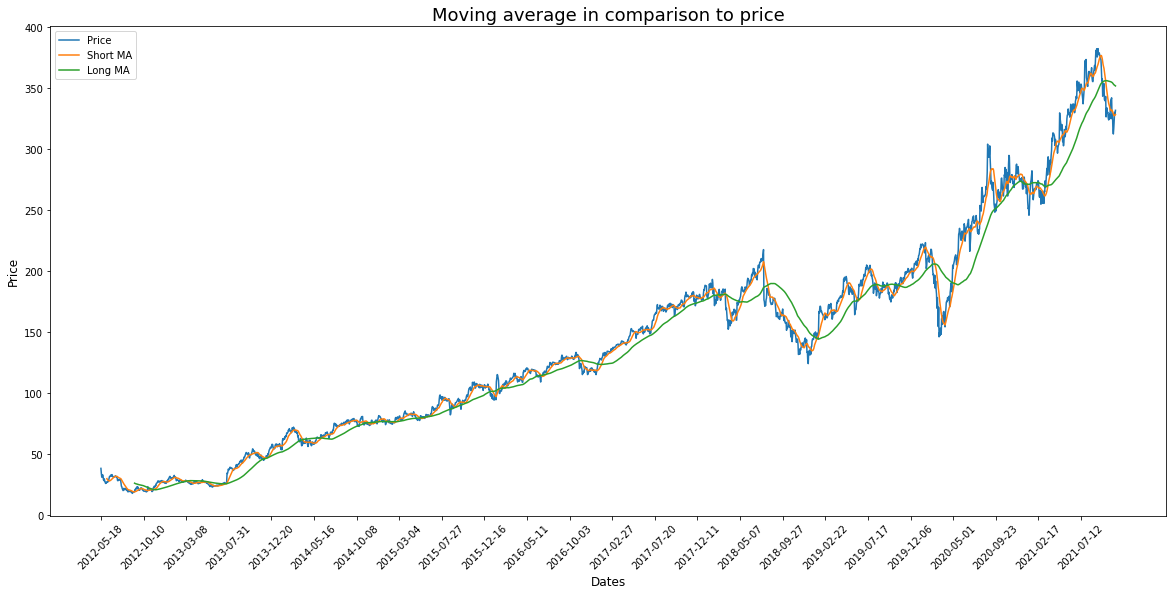

In [7]:
plt.figure(figsize=(20,9))

plt.xlabel('Dates',fontsize=12)
plt.ylabel('Price',fontsize=12)
plt.title('Moving average in comparison to price',fontsize=18)

plt.plot(meta.Date,meta.Close,label='Price')
plt.plot(meta.Date,short_MA.Close, label='Short MA')
plt.plot(meta.Date,long_MA.Close,label='Long MA')

plt.xticks(range(0,meta.shape[0],100),meta.Date.loc[::100],rotation=45)

plt.legend()
plt.show()

From the graph above, we have decided that for this project, including the entire date range will be beneficial. This is because there is a variation in patterns across the years. All of it can be taken into account when training our models.

In [8]:
#Method 1

In [9]:
from sklearn.model_selection import train_test_split
training_set, test_set = train_test_split(meta, test_size = 0.2, random_state = 21)

training_set.drop(['Adj Close'], axis = 1, inplace = True)
test_set.drop(['Adj Close'], axis = 1, inplace = True)

X_train_array = training_set.iloc[:,1:-1].values
y_train_array = training_set.iloc[:,0:1].values

X_test_array = test_set.iloc[:,1:-1].values
y_test_array = test_set.iloc[:,0:1].values

In [10]:
import torch
from d2l import torch as d2l
from torch.utils.data import Dataset

training = torch.tensor(X_train_array, dtype=torch.float32)
test = torch.tensor(X_test_array, dtype=torch.float32)
trainlabels = torch.tensor(y_train_array, dtype=torch.float32)
testlabels = torch.tensor(y_test_array, dtype=torch.float32)

MLP model 1:

In [11]:
#MLP model set up with activation functions 
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens):
        super(MLP, self).__init__()
        self.hidden = nn.Linear(num_input, num_hidden) #Using fully connected layers - need to justify
        nn.init.kaiming_uniform_(self.hidden.weight) #Explain why we used He initialisation
        self.activation = nn.ReLU() #also need to explain choice of ReLU
        self.out = nn.Linear(num_hidden, num_output)

    def forward(self, X):
        X = self.hidden(X)
        X = self.activation(X)
        X = self.out(X)
        return X

In [12]:
#Model structure
num_input, num_output, num_hidden = 4, 1, 2
model_1 = MLP(num_input, num_output, num_hidden)

In [13]:
#Loss function
loss = nn.MSELoss()

def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

#Model trainer
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, batch_size):
    training_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.SGD(net.parameters(), lr = learning_rate)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            y_train_pred = net(X)
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        training_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return training_ls, test_ls

#Plotting losses
def train_and_pred(model, train_features, test_features, train_labels, test_labels, num_epochs, lr, batch_size):
    net = model
    train_ls, valid_ls = train(net, train_features, train_labels, test_features, test_labels, num_epochs, lr, batch_size)
    d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls], xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs], legend=['train', 'valid'], yscale='log')  
    print(f'train log rmse {float(train_ls[-1]):f}, 'f'valid log rmse {float(valid_ls[-1]):f}')

train log rmse 0.790579, valid log rmse 0.762137


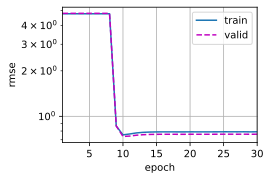

In [14]:
train_and_pred(model_1, training, test, trainlabels, testlabels, 30, 0.001, 5)

In [15]:
#Method 2

In [16]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import torch

In [17]:
training_set, test_set = train_test_split(meta, test_size = 0.2, random_state = 21)

training_set.drop(['Date', 'Adj Close'], axis = 1, inplace = True)
test_set.drop(['Date', 'Adj Close'], axis = 1, inplace = True)

In [18]:
X_train_array = training_set.iloc[:,1:].values
y_train_array = training_set.iloc[:,0:1].values

X_test_array = test_set.iloc[:,1:].values
y_test_array = test_set.iloc[:,0:1].values

In [19]:
scaler = StandardScaler()

X_train = torch.tensor(scaler.fit_transform(X_train_array), dtype = torch.float32)
y_train = torch.tensor(scaler.fit_transform(y_train_array), dtype = torch.float32)

X_test = torch.tensor(scaler.fit_transform(X_test_array), dtype = torch.float32)
y_test = torch.tensor(scaler.fit_transform(y_test_array), dtype = torch.float32)

In [20]:
#Training dataset
class trainingdataset(Dataset):
    def __init__(self): #Loading in the data
        xy = training_set.values
        self.x = torch.from_numpy(xy[:,1:].astype(np.float32))
        self.y =  torch.from_numpy(xy[:,[0]].astype(np.float32))
        self.samples = xy.shape[0]
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]
        
    def __len__(self):
        return self.samples

In [21]:
training = trainingdataset()

#Testing if it works
#first_data = training[0]
#features, labels = first_data
#print(features, labels)

batch_size = 50
train_dl = DataLoader(dataset = training, batch_size = batch_size, shuffle = True)

In [22]:
# batch_size = 50
#meta_dl = DataLoader(dataset = meta_dataset, batch_size = batch_size, shuffle = True)

#meta_iter = iter(meta_dl)
#data = meta_iter.next()
#features, labels = data

In [23]:
#Testing data
class testingdataset(Dataset):
    def __init__(self): 
        xy = test_set.values
        self.x = torch.from_numpy(xy[:,1:].astype(np.float32))
        self.y =  torch.from_numpy(xy[:,[0]].astype(np.float32))
        self.samples = xy.shape[0]
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]
        
    def __len__(self):
        return self.samples
    
testing = testingdataset()
test_dl = DataLoader(dataset = testing, batch_size = batch_size, shuffle = True)

In [24]:
#MLP model set up with activation functions 
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens):
        super(MLP, self).__init__()
        self.hidden = nn.Linear(num_input, num_hidden) #Using fully connected layers - need to justify
        nn.init.kaiming_uniform_(self.hidden.weight) #Explain why we used He initialisation
        self.activation = nn.ReLU() #also need to explain choice of ReLU
        self.out = nn.Linear(num_hidden, num_output)

    def forward(self, X):
        X = self.hidden(X)
        X = self.activation(X)
        X = self.out(X)
        return X

In [25]:
num_input, num_output, num_hidden = 4, 1, 2
model_1 = MLP(num_input, num_output, num_hidden)

In [26]:
#Optimiser functions
lr, num_epochs = 0.2, 60
criterion_1 = nn.MSELoss()
updater_1 = torch.optim.SGD(model_1.parameters(), lr = lr, momentum = 0.9)

In [27]:
#Training the model - try 1
def log_rmse(model, inputs, labels, criterion):
    clipped_preds = torch.clamp(model(inputs), 1, float('inf'))
    rmse = torch.sqrt(criterion(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

def MLP_model_trainer(model, train_dataloader, criterion, updater):
    train_loss = []
    for epoch in range(num_epochs):
        for i, train_data in enumerate(train_dataloader):
            train_inputs, train_labels = train_data
            updater.zero_grad()
            y_hat = model(train_inputs)
            loss = criterion(y_hat, train_labels)
            loss.backward()
            updater.step()
        train_loss.append(log_rmse(model, train_inputs, train_labels, criterion))
    return train_loss

def MLP_model_evaluater(model, test_dataloader, criterion):
    test_loss = []
    for i, test_data in enumerate(test_dataloader):
        test_inputs, test_labels = test_data
    test_loss.append(log_rmse(model, test_inputs, test_labels, criterion))
    return test_loss

In [28]:
#Training the model - try 2
def log_rmse(model, inputs, labels, criterion):
    clipped_preds = torch.clamp(model(inputs), 1, float('inf'))
    rmse = torch.sqrt(criterion(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

def MLP_model_trainer(model, train_dataloader, test_dataloader, criterion, updater):
    model.train()
    training_ls, test_ls = [], []
    for epoch in range(num_epochs):
        for i, train_data in enumerate(train_dataloader):
            train_features, train_labels = train_data
            updater.zero_grad()
            loss = criterion(model(train_features), train_labels)
            loss.backward()
            updater.step()
        training_ls.append(log_rmse(model, train_features, train_labels, criterion))
        
        for i, test_data in enumerate(test_dataloader):
            test_features, test_labels = test_data
        if test_labels is not None:
            test_ls.append(log_rmse(model, test_features, test_labels, criterion))
    return training_ls, test_ls

In [29]:
m1_train_loss, m1_test_loss = MLP_model_trainer(model_1, train_dl, test_dl, criterion_1, updater_1)

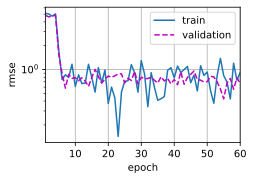

In [30]:
from d2l import torch as d2l
d2l.plot(list(range(1, num_epochs + 1)), [m1_train_loss, m1_test_loss], xlabel = 'epoch', ylabel = 'rmse', xlim = [1, num_epochs], legend = ['train', 'validation'], yscale = 'log')  

MLP model 2:

In [31]:
#New model structure
num_input, num_output, num_hidden = 14, 1, 10 #2 week window
model_2 = MLP(num_input, num_output, num_hidden)

In [32]:
criterion_2 = nn.MSELoss()
updater_2 = torch.optim.SGD(model_2.parameters(), lr = lr, momentum = 0.9)

In [57]:
#MLP model 2 with sliding window & dropout - Refer to Rafay's code

RNN attempt 1:

In [34]:
#Sliding window data
def sliding_window(data, timeframe):
    numpydata = data.to_numpy() 
    data = []

    # create all possible sequences of length seq_len
    for index in range(len(numpydata) - timeframe): 
        data.append(numpydata[index: index + timeframe])

    return np.array(data)

sw_meta = sliding_window(meta.iloc[:,0:1], 15)

In [35]:
meta_data = pd.DataFrame(sw_meta.T.reshape(-1, 15))
meta_data.columns = ['Day 1', 'Day 2', 'Day 3', 'Day 4', 'Day 5', 'Day 6', 'Day 7', 'Day 8', 'Day 9', 'Day 10', 'Day 11', 'Day 12', 'Day 13', 'Day 14', 'Target']
meta_data = meta_data[['Target'] + [col for col in meta_data.columns if col != 'Target' ]]

In [36]:
from sklearn.model_selection import train_test_split

def feature_label_split(dataframe, target):
    y = dataframe.iloc[:,0:1]
    X = dataframe.iloc[:,1:]
    return X, y

def train_val_test_split(dataframe, target, test_ratio):
    val_ratio = test_ratio / (1 - test_ratio)
    X, y = feature_label_split(dataframe, target)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_ratio, shuffle = False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = val_ratio, shuffle = False)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [37]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(meta_data, 'Target', 0.2)

In [38]:
#Scaling datasets
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_array = scaler.fit_transform(X_train)
X_val_array = scaler.transform(X_val)
X_test_array = scaler.transform(X_test)

y_train_array = scaler.fit_transform(y_train)
y_val_array = scaler.transform(y_val)
y_test_array = scaler.transform(y_test)

In [39]:
import torch
from torch.utils.data import TensorDataset

train_feat = torch.Tensor(X_train_array)
train_targ = torch.Tensor(y_train_array)
val_feat = torch.Tensor(X_val_array)
val_targ = torch.Tensor(y_val_array)
test_feat = torch.Tensor(X_test_array)
test_targ = torch.Tensor(y_test_array)

training_set = TensorDataset(train_feat, train_targ)
valid_set = TensorDataset(val_feat, val_targ)
test_set = TensorDataset(test_feat, test_targ)

In [40]:
from torch.utils.data import DataLoader

batch_size = 50
train_dl = DataLoader(training_set, batch_size =  batch_size, drop_last = True)
val_dl = DataLoader(valid_set, batch_size =  batch_size, drop_last = True)
test_dl = DataLoader(test_set, batch_size =  batch_size, drop_last = True)

In [42]:
#Loss function
loss = nn.MSELoss()

def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

#Model trainer
def RNN_model_trainer(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, batch_size):
    training_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.SGD(net.parameters(), lr = learning_rate)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        training_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return training_ls, test_ls

#Plotting losses
def RNN_train_and_pred(model, train_features, test_features, train_labels, test_labels, num_epochs, lr, batch_size):
    net = model
    train_ls, valid_ls = train(net, train_features, train_labels, test_features, test_labels, num_epochs, lr, batch_size)
    d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls], xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs], legend=['train', 'valid'], yscale='log')  
    print(f'train log rmse {float(train_ls[-1]):f}, 'f'valid log rmse {float(valid_ls[-1]):f}')

In [ ]:
#Optimiser
class Optimization():
    def __init__(self, model, criterion, updater):
        self.model = model
        self.criterion = criterion
        self.updater = updater
        self.train_losses = []
        self.valid_losses = []
        
        def training_step(self, inputs, labels):
            self.model.train()
            y_hat = self.model(inputs)
            loss = self.criterion(labels, y_hat)
            loss.backward()
            self.updater.step()
            self.updater.zero_grad()
            return loss.item()

In [ ]:
#Training the model
def RNN_model_trainer(self, train_dataloader, val_dataloader, batch_size, num_epochs, num_features):
    for epoch in range(1, num_epochs + 1):
        batch_loss = []
        for train_inputs, train_labels in train_loader:
            train_inputs = train_inputs.view([batch_size, -1, num_features]).to(device)
            train_labels = train_labels.to(device)
            loss = self.training_step(train_inputs, train_labels)
            batch_loss.append(loss)
            training_loss = np.mean(batch_loss)
            self.train_losses.append(training_loss)
            
            with torch.no_grad():
                batch_val_loss = []
                for val_inputs, val_labels in val_loader:
                    val_inputs = val_inputs.view([batch_size, -1, num_features]).to(device)
                    val_labels = val_labels.to(device)
                    self.model.eval()
                    y_hat = self.model(val_inputs)
                    val_loss = criterion(val_labels, y_hat).item()
                    batch_val_loss.append(val_loss)
                validation_loss = np.mean(batch_val_loss)
                self.valid_losses.append(validation_loss)

In [ ]:
#RNN model
class RNN(nn.Module):
    def __init__(self, num_inputs, hidden_dims, layer_dims, num_outputs):
        super(RNN, self).__init__()
        self.hidden_dims = hidden_dims #Numer of features in the hidden state
        self.layer_dims = layer_dims #Number of recurrent layers
        self.rnn = nn.RNN(num_inputs, hidden_dim, layer_dim, batch_first = True)
        self.fc = nn.Linear(hidden_dim, num_outputs)
        
    def forward(self, X):
        h_0 = torch.zeros(self.layer_dim, X.size(0), self.hidden_dim).requires_grad_()
        out, h_0 = self.rnn(X, h_0.detach())
        out = out[:,-1,:]
        out.self.fc(out)
        return out

In [ ]:
#RNN model
num_input, hidden_dim, layer_dim, num_output = 14, 15, 2, 1
rnn_model = RNN(num_input, hidden_dim, layer_dim, num_output)

In [ ]:
lr, num_epochs = 0.2, 60
criterion_3 = nn.MSELoss()
updater_3 = torch.optim.SGD(rnn_model.parameters(), lr = lr)

In [ ]:
from datetime import datetime

opt = Optimization(model = rnn_model, criterion = criterion_3, updater = updater_3)

In [ ]:
opt.RNN_model_trainer(train_dataloader = train_dl, val_dataloader = val_dl, batch_size = 50, num_epochs = num_epochs, num_features = num_input)

In [ ]:
#Model trainer
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, batch_size):
    training_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.SGD(net.parameters(), lr = learning_rate)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        training_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return training_ls, test_ls

In [ ]:
import torch.optim as optim

num_input, hidden_dim, layer_dim, num_output = 14, 64, 3, 1
batch_size, num_epochs, lr = 50, 50, 0.05

criterion_3 = nn.MSELoss(reduction = 'mean')
updater_3 = torch.optim.SGD(rnn_model.parameters(), lr = lr)
opt = Optimization(model = rnn_model, criterion = criterion_3, updater = updater_3)

In [ ]:
opt.RNN_model_trainer(train_dl, val_dl, batch_size, num_epochs, num_input)
opt.plot_losses()

RNN model attempt 2:

In [ ]:
meta_data

In [ ]:
training_set, test_set = train_test_split(meta, test_size = 0.2, shuffle = False)

In [ ]:
train_array = training_set.iloc[:,0:1]
test_array = test_set.iloc[:,0:1]

In [ ]:
#Sliding window data
def sliding_window(values, window_size):
    dataset = []
    if len(values) < window_size:
        return values.values
    for i in range(len(values)):
        dataset.append(values[i:i+window_size])
    return dataset

In [ ]:
def sliding_window(data, timeframe):
    numpydata = data.to_numpy() 
    data = []

    # create all possible sequences of length seq_len
    for index in range(len(numpydata) - timeframe): 
        data.append(numpydata[index: index + timeframe])

    return np.array(data)

In [ ]:
rnn_training = sliding_window(train_array, 16)
rnn_testing = sliding_window(test_array, 16)

In [ ]:
from torch.utils.data import Dataset

class trainingdataset(Dataset):
    def __init__(self): #Loading in the data
        xy = rnn_training
        self.x = torch.from_numpy(xy[:,0:-2].astype(np.float32)) #Slice the first 14 values for the inputs
        self.y =  torch.from_numpy(xy[:,[-1]].astype(np.float32)) #15th value for the labels
        self.samples = xy.shape[0]
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]
        
    def __len__(self):
        return self.samples

In [ ]:
class testingdataset(Dataset):
    def __init__(self): #Loading in the data
        xy = rnn_testing
        self.x = torch.from_numpy(xy[:,0:-2].astype(np.float32))
        self.y =  torch.from_numpy(xy[:,[-1]].astype(np.float32))
        self.samples = xy.shape[0]
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]
        
    def __len__(self):
        return self.samples

In [ ]:
training = trainingdataset()
batch_size = 50
train_dl = DataLoader(dataset = training, batch_size = batch_size, shuffle = True)

In [ ]:
testing = testingdataset()
test_dl = DataLoader(dataset = testing, batch_size = batch_size, shuffle = True)

In [ ]:
first_data = training[0]
features, labels = first_data
print(features, labels)

In [ ]:
#RNN model 
class RNN(nn.Module):
    def __init__(self, num_inputs, num_hiddens, num_outputs):
        super(RNN, self).__init__()
        self.num_hiddens = num_hiddens
        self.hidden = nn.Linear(num_inputs + num_hiddens, num_hiddens) 
        #Hidden layer includes information from both inputs and hidden layer itself
        self.out = nn.Linear(num_inputs + num_hiddens, num_outputs)
    
    #Forward step with the hidden state
    def forward(self, X, hidden_state):
        combined = torch.cat((X, hidden_state), 1) 
        hidden = torch.sigmoid(self.hidden(combined))
        output = self.out(combined)
        return output, hidden
    
    #Initialising hidden state
    def init_hidden(self):
        return torch.nn.init.xavier_normal_(self.hidden.weight, gain = 1.0)

In [ ]:
num_input, num_hidden, num_output = 14, 10, 1
rnn_model = RNN(num_input, num_hidden, num_output)

In [ ]:
lr, num_epochs = 0.2, 60
criterion_3 = nn.MSELoss()
updater_3 = torch.optim.SGD(rnn_model.parameters(), lr = lr, momentum = 0.9)

In [ ]:
#Training the model
def RNN_model_trainer(model, dataloader, criterion, updater):
    train_loss = []
    for epoch in range(num_epochs):
        for i, data in enumerate(dataloader):
            inputs, labels = data
            hidden_state = model.init_hidden() 
            updater.zero_grad()
            for i in inputs:
                y_hat, hidden_state = model(i, hidden_state)
            loss = criterion(y_hat, labels)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1)
            updater.step()
        train_loss.append(log_rmse(model, inputs, labels, criterion))
    return train_loss

In [ ]:
first_data = training[0]
inputs, labels = first_data
print(inputs, labels)

In [ ]:
RNN_model_trainer(rnn_model, train_dl, criterion_3, updater_3)

RNN model attempt 3:

In [46]:
import pandas as pd
import numpy as np
from numpy import zeros, newaxis

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from sklearn.preprocessing import MinMaxScaler
import math, time
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

In [47]:
url = 'FB.csv'
meta = pd.read_csv(url)
meta = meta.dropna(how='any',axis = 0) #If there is missing data
meta['Date'].apply(pd.to_datetime) #For ease of adjusting dates later on
len(meta.index)

2382

In [48]:
meta = meta[['Close'] + [col for col in meta if col not in ['Adj Close', 'Close']] + ['Adj Close']]

In [49]:
meta = meta.sort_values('Date')
meta.head()

,Close,Date,Open,High,Low,Volume,Adj Close
0,38.230000,2012-05-18,42.049999,45.000000,38.000000,573576400,38.230000
1,34.029999,2012-05-21,36.529999,36.660000,33.000000,168192700,34.029999
2,31.000000,2012-05-22,32.610001,33.590000,30.940001,101786600,31.000000
3,32.000000,2012-05-23,31.370001,32.500000,31.360001,73600000,32.000000
4,33.029999,2012-05-24,32.950001,33.209999,31.770000,50237200,33.029999


In [50]:
closing = meta[['Close']]

In [51]:
#Function for normalising data
scaler = MinMaxScaler(feature_range=(-1, 1))

def split_data(prices, window):
    raw = prices.to_numpy()
    data = []
    
    for index in range(len(raw) - window): 
        data.append(raw[index: index + window])
    
    data = np.array(data)
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)
    
    X_train = data[:train_set_size,:-1,]
    X_train = scaler.fit_transform(X_train.reshape(-1,1))
    X_train = X_train.reshape(train_set_size, window - 1, 1)
    y_train = data[:train_set_size,-1,:]
    y_train = scaler.fit_transform(y_train)
    
    X_test = data[:test_set_size,:-1,]
    X_test = scaler.fit_transform(X_test.reshape(-1,1))
    X_test = X_test.reshape(test_set_size, window - 1, 1)
    y_test = data[:test_set_size,-1,]
    y_test = scaler.fit_transform(y_test)
    
    return [X_train, y_train, X_test, y_test]

In [52]:
window_size = 14 #14 input values and 15th value is the target
X_train, y_train, X_test, y_test = split_data(closing, window_size)

In [53]:
#Converting data to tensors for the model
X_train = torch.from_numpy(X_train).type(torch.Tensor)
X_test = torch.from_numpy(X_test).type(torch.Tensor)
y_train_rnn = torch.from_numpy(y_train).type(torch.Tensor)
y_test_rnn = torch.from_numpy(y_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

In [54]:
#RNN model
class RNN(nn.Module):
    def __init__(self, num_inputs, num_hiddens, num_layers, num_outputs):
        super(RNN, self).__init__()
        self.num_hiddens = num_hiddens #Number of neurons in the hidden layer
        self.num_layers = num_layers #Number of hidden layers
        self.rnn = nn.RNN(num_inputs, num_hiddens, num_layers, batch_first = True) #RNN layer includes inputs and hidden states
        self.fc = nn.Linear(num_hiddens, num_outputs) #Output
        
    def forward(self, X):
        #Initialising hidden state
        h0 = torch.zeros(self.num_layers, X.size(0), self.num_hiddens).requires_grad_()
        out, h_state = self.rnn(X, h0.detach())
        out = self.fc(out[:, -1, :]) 
        return out

In [55]:
num_input, num_hidden, num_layer, num_output = 1, 20, 1, 1
rnn_model = RNN(num_input, num_hidden, num_layer, num_output)

In [56]:
num_epochs, lr = 100, 0.01
rnn_criterion = nn.MSELoss(reduction = 'mean')
rnn_updater = torch.optim.Adam(rnn_model.parameters(), lr = lr)

In [ ]:
#Training RNN model
train_hist_rnn = np.zeros(num_epochs)

for epoch in range(num_epochs):
    y_train_pred = rnn_model(X_train)

    loss = rnn_criterion(y_train_pred, y_train_rnn)
    train_hist_rnn[epoch] = loss.item()
    if epoch % 5 == 0:
        print("Epoch ", epoch, "MSE: ", loss.item())
    rnn_updater.zero_grad()
    loss.backward()
    rnn_updater.step()

In [ ]:
#RNN model performance on testing data
y_test_pred = rnn_model(X_test)

In [ ]:
#Converting the data back to its original form
rnn_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
rnn_train_orig = scaler.inverse_transform(y_train_rnn.detach().numpy())
rnn_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
rnn_test_orig = scaler.inverse_transform(y_test_rnn.detach().numpy())

In [ ]:
#Calculating the RMSE for training and testing data
train_rnn_RMSE = math.sqrt(mean_squared_error(y_train_orig[:,0], y_train_pred[:,0]))
print('Train RMSE: %.2f' % (train_rnn_RMSE))
test_rnn_RMSE = math.sqrt(mean_squared_error(y_test_orig[:,0], y_test_pred[:,0]))
print('Test RMSE: %.2f' % (test_rnn_RMSE))

LSTM model:

nn.LSTM documentation: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

In [ ]:
#LSTM model
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim #Number of neurons in hidden layer
        self.num_layers = num_layers #Number of hidden layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True) #LSTM layer
        self.fc = nn.Linear(hidden_dim, output_dim) #Output layer

    def forward(self, x):
        #Intialising hidden state
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        #Intialising cell state
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h_0.detach(), c_0.detach())) 
        out = self.fc(out[:, -1, :]) 
        return out

In [ ]:
num_input, num_hidden, num_layer, num_output = 1, 20, 1, 1
lstm_model = LSTM(num_input, num_hidden, num_layer, num_output)

In [ ]:
num_epochs, lr = 100, 0.01
lstm_criterion = nn.MSELoss(reduction = 'mean')
lstm_updater = torch.optim.Adam(lstm_model.parameters(), lr = lr)

In [ ]:
#Training LSTM model
train_hist_lstm = np.zeros(num_epochs)

for epoch in range(num_epochs):
    y_train_pred = lstm_model(X_train)

    loss = lstm_criterion(y_train_pred, y_train_lstm)
    train_hist_lstm[epoch] = loss.item()
    if epoch % 5 == 0:
        print("Epoch ", epoch, "MSE: ", loss.item())
    lstm_updater.zero_grad()
    loss.backward()
    lstm_updater.step()

In [ ]:
#LSTM model performance on testing data
y_test_pred = lstm_model(X_test)

In [ ]:
#Converting the data back to its original form
lstm_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
lstm_train_orig = scaler.inverse_transform(y_train_lstm.detach().numpy())
lstm_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
lstm_test_orig = scaler.inverse_transform(y_test_lstm.detach().numpy())

In [ ]:
#Calculating the RMSE for training and testing data
train_lstm_RMSE = math.sqrt(mean_squared_error(lstm_train_orig[:,0], lstm_train_pred[:,0]))
print('Train RMSE: %.2f' % (train_rnn_RMSE))
test_lstm_RMSE = math.sqrt(mean_squared_error(lstm_test_orig[:,0], lstm_test_pred[:,0]))
print('Test RMSE: %.2f' % (test_lstm_RMSE))